### Backup 2: The DeepRitz-Method

While PINNs usually utilize the strong formulation of the PDE, there are other concepts that use different formulations of the PDE for training the network, one of them is the DeepRitz method. There, the energy formulation
of the problem is used.

Let us considere the following simple Laplace equation with a singularity at (0, 0):
\begin{align*}
    -\Delta u &= 1 \text{ in } \Omega, \\
    u &= 0 \text{ on } \partial \Omega,
\end{align*} 

with $\Omega=([-1, 1] \times [-1, 1]) \setminus ([0, 1] \times \{0\})$.

Then the energy functional for this problem is given by:
\begin{equation}
    E(v) = \int_\Omega \frac{1}{2}\|\nabla v\|^2 \text{d}x
\end{equation}
The solution $u$ of the strong formulation minimizes the energy functional, namely $E(u) \leq E(v)$ for all $v$ in the corresponding function space.

The DeepRitz method still tries to learn the solution $u$, but now minimizes $E$ in the training instead of using the strong formulation. To include the boundary condition, the functional also is extended:
\begin{equation}
    E(v) = \int_\Omega \frac{1}{2}\|\nabla v\|^2 \text{d}x + \int_{\partial\Omega} \frac{1}{2}\|v\|^2 \text{d}o
\end{equation}

The following cells, show the usage of DeepRitz in TorchPhysics.

In [8]:
!pip install torchaudio==0.13.0
!pip install torchphysics

In [9]:
import torchphysics as tp 
import torch
import pytorch_lightning as pl

X = tp.spaces.R1('x') 
Y = tp.spaces.R1('y')
U = tp.spaces.R1('u')

In [10]:
# TODO: Implement the square [-1, 1] x [-1, 1] 
square = tp.domains.Parallelogram(X*Y, [-1, -1], [1, -1], [-1, 1])
line = tp.domains.Interval(X, 0, 1) * tp.domains.Point(Y, 0)

In [11]:
# Here we create the sampler. For DeepRitz we need to approximate the integral, therefore one usually needs more points
# then in the PINN approach to get a good estimate.
# But since in the energy functional the derivatives are of lower order, this generally does not lead to memory problems.
inner_sampler = tp.samplers.RandomUniformSampler(square, n_points=100000) 

bound_sampler = tp.samplers.RandomUniformSampler(square.boundary, n_points=40000)
bound_sampler += tp.samplers.RandomUniformSampler(line, n_points=10000)

The classic DeepRitz method uses a ResNet-architecture instead of a FCN. This is also implemented and used here: 

In [12]:
# TODO: Add the input and output space
model = tp.models.DeepRitzNet(input_space=X*Y, output_space=U, width=20, depth=4)

The transformation of the mathematical equations is handled similar to the PINN approach. For each integral in the energy functional, we define a condition.

Instead of a *PINNCondition*, we now use a *DeepRitzCondition*. While the *PINNCondition* compute the mean squared error over the output of the residual function, the *DeepRitzCondition* only sums up the output to approximate the interval.

In [13]:
# The integral for the boundary
def bound_residual(u):
    return u**2

bound_cond = tp.conditions.DeepRitzCondition(module=model, sampler=bound_sampler, 
                                             integrand_fn=bound_residual, weight=100)

In [14]:
# The integral for the inner part.
# TODO: Following the implementation in the above cell, complete the condition below:
#       Hint: to compute the norm over a batch of vectors called v, the call
#       torch.sum(v, dim=1, keepdim=True) is useful.
def energy_residual(u, x, y):
    grad_term = torch.sum(tp.utils.grad(u, x, y)**2, dim=1, keepdim=True)
    return 0.5*grad_term - u

pde_cond = tp.conditions.DeepRitzCondition(module=model, sampler=inner_sampler, 
                                           integrand_fn=energy_residual, weight=1.0)

In [15]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver(train_conditions=[bound_cond, pde_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1, # or None if CPU is used
                     max_steps=4000, # number of training steps
                     logger=False,
                     benchmark=True,
                     enable_checkpointing=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 3.4 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

We can also use different optimizer algorithms, like LBFGS to may get better convergence.

One point we have to keep in mind, is to fix the inputs of the neural network for LBFGS to work.

In [16]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.05, 
                            optimizer_args={'max_iter': 2, 'history_size': 100})

pde_cond.sampler = pde_cond.sampler.make_static() 
bound_cond.sampler = bound_cond.sampler.make_static() 
solver = tp.solver.Solver(train_conditions=[bound_cond, pde_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=2000, # number of training steps
                     logger=False,
                     benchmark=True,
                     enable_checkpointing=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 3.4 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/domain2D/parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)
/home/tomfre/Desktop/torchphysics/src/torchphysics/utils/plotting/plot_functions.py:416: UserWarning: Creating a tensor from a list of 

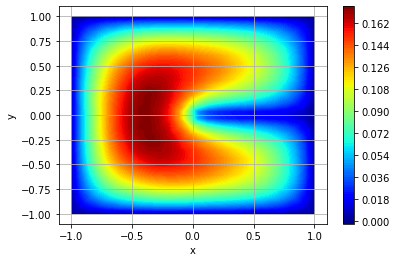

In [17]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=square, n_points=640, device='cuda')
fig = tp.utils.plot(model, lambda u : u, plot_sampler, plot_type='contour_surface')